![](resource/ECG-waves.jpg)

sumber : [link](https://litfl.com/qt-interval-ecg-library/)

In [1]:
import os 
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
data_type = 'Normal' # pilih 'Normal' untuk normal dan 'AF' untuk atrial fibrilliation

folder_dataset = "dataset/data pasien/pasien %s" % data_type

os.listdir(folder_dataset)

['Fikar.csv', 'Hari.csv', 'Ikhsan.csv', 'Imam.csv', 'Putu.csv', 'Zein.csv']

In [3]:
filename = 'Hari.csv'

In [4]:
# read dataset, skip first row
ECG = pd.read_csv(os.path.join(folder_dataset, filename), skiprows = [0])

ECG.columns = ['Time', 'ECG']

ECG.head()

,Time,ECG
0,21:52:01.195,6089087.0
1,21:52:01.235,6088970.0
2,21:52:01.275,6089081.0
3,21:52:01.315,6089420.0
4,21:52:01.355,6089478.0


In [5]:
# replace not required char in Time_norm Series 
# ECG["Time_norm"] = ECG.Time.apply(lambda x:  "00:0" + x.replace("[", "") \
#                                                       .replace("]", "") \
#                                                       .replace("'", "") \
#                                                       .replace("'",""))

# create Series with dtype Time
ECG["Idx_Time"] = pd.to_datetime(ECG["Time"]) #, errors='coerce', format="%H:%M:%S.%f")

#Set Time as Index
ECG.index = ECG["Idx_Time"]

# delete unused column 
ECG.drop('Idx_Time', axis=1, inplace=True)
# ECG.drop('Time_norm', axis=1, inplace=True)
ECG.drop('Time', axis=1, inplace=True)

In [6]:
# set sampling rate
fs = 25 #Hz

In [7]:
def plot_signal(data, fs, label="ECG sample raw data"):
    plt.figure(figsize=(20, 5))
    plt.ylabel("Amplitude")

    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.plot(times, data)
    plt.xlabel("Time (s)")
    plt.title(label)
    plt.grid(True)
    plt.show()

In [8]:
ECG.tail()

,ECG
Idx_Time,
2020-12-24 21:57:12.435,6089758.0
2020-12-24 21:57:12.475,6091941.0
2020-12-24 21:57:12.515,6091022.0
2020-12-24 21:57:12.555,6090469.0
2020-12-24 21:57:12.595,6090668.0


In [9]:
str(ECG.index.min().time()), str(ECG.index.max().time())

('21:52:01.195000', '21:57:12.595000')

21:52:01.195000 21:52:17.195000


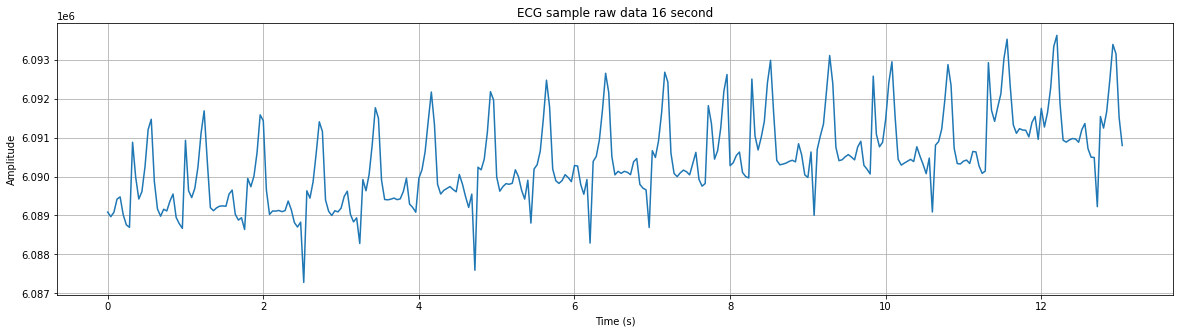

In [10]:
start = ECG.index[0].time()
end = (ECG.index[0] + datetime.timedelta(seconds=16)).time()
print(start, end)

plot_signal(ECG.between_time(start, end), fs, "ECG sample raw data 16 second")

21:52:33.195000 21:52:49.195000


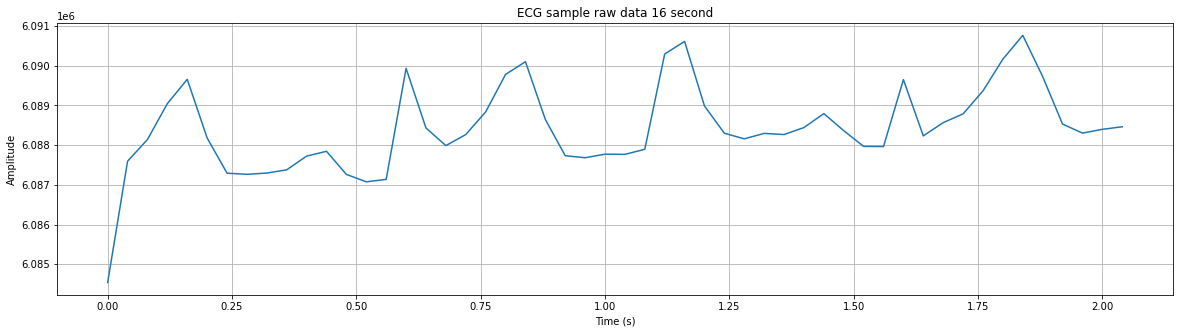

In [11]:
start = (ECG.index[0] + datetime.timedelta(seconds=32)).time()
end = (ECG.index[0] + datetime.timedelta(seconds=48)).time()
print(start, end)

plot_signal(ECG.between_time(start, end), fs, "ECG sample raw data 16 second")

___
## Baseline Wander Removal
### Asymmetric Least Squares Smoothing

In [12]:
from scipy.signal import argrelextrema

In [13]:
from scipy.signal import find_peaks 

In [14]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [15]:
def plot_16s_sample(original, als, baseline, label="Plot 16 s sample"):
    times = np.arange(len(original), dtype='float') / fs
    
    plt.figure(figsize=(20, 10))
    plt.subplot(2,1,1)
    plt.plot(times, original)
    plt.plot(times, baseline)
    plt.legend(['original signal', 'baseline'])
    plt.title(label)
    plt.grid(True)
    plt.subplot(2,1,2)
    plt.plot(times, als)
    plt.legend(['signal - als'])
    plt.grid(True)
    plt.show()

In [16]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

- apply to all sample signal

In [17]:
ECG.index.min(), ECG.index.max()

(Timestamp('2020-12-24 21:52:01.195000'),
 Timestamp('2020-12-24 21:57:12.595000'))

In [18]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
time_interval = [time_result for time_result in perdelta(ECG.index.min(), ECG.index.max(), timedelta(seconds=16))]

In [19]:
ECG_ALS = []
BASELINE_ALS = []
ORI = []
for time_intv in list(zip(time_interval, time_interval[1:])):
    X = ECG.between_time(time_intv[0].time(), time_intv[1].time())
    X_val = X.values[:,0]
    if len(X_val) > 0 :
        
#         min_id = argrelextrema(X_val, np.less, order=7)[0]
#         h = np.mean(X_val) + np.std(X_val)
        
#         max_id = find_peaks(X_val, height=h)[0] 
        
#         max_val = np.mean(X_val) + (np.max([X_val[i] for i in range(len(X_val)) if i in max_id]) - np.mean(X_val))*0.5
#         min_val = np.mean(X_val) - (max_val - np.mean(X_val))
         
#         for idx in max_id:
#             X_val[idx] = max_val
#         for idx in min_id:
#             X_val[idx] = min_val
        
        baseline = baseline_als(X_val)
        ALS = X_val - baseline
        
        ORI.append(X_val)
        ECG_ALS.append(np.array(ALS))
        BASELINE_ALS.append(baseline)

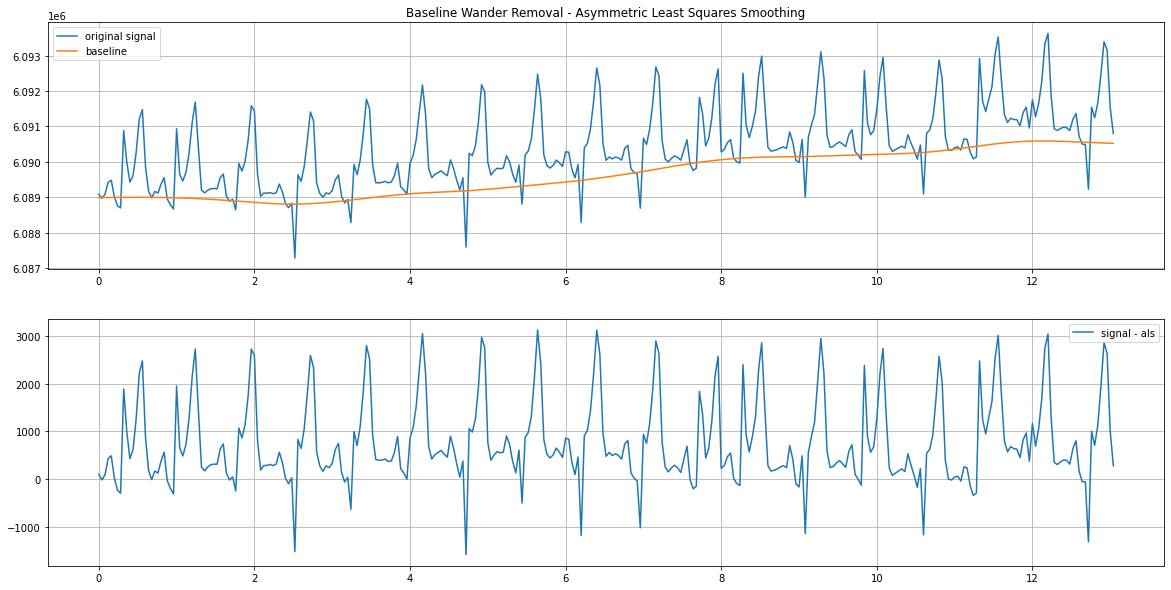

In [20]:
plot_16s_sample(ORI[0], ECG_ALS[0], BASELINE_ALS[0], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing")

___
## Signal Normalization

In [21]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler


In [22]:
scaler = MaxAbsScaler()
ECG_Norm = []

for als in ECG_ALS :
    als = np.expand_dims(als, 1)
    scaler = scaler.fit(als)
    
    als_norm = scaler.transform(als) 
    ECG_Norm.append(als_norm)

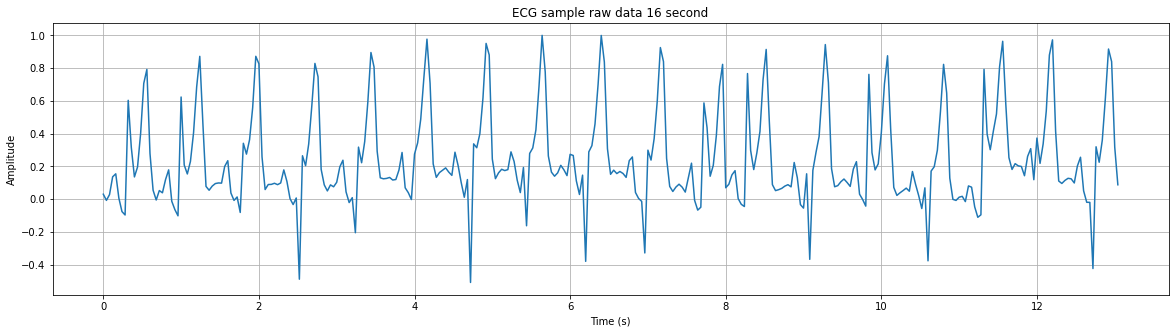

In [23]:
plot_signal(ECG_Norm[0], fs, "ECG sample raw data 16 second")

___

## QRS Detection

pip package : `pip install py-ecg-detectors`

In [24]:
from ecgdetectors import Detectors


In [25]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.grid(True)
    plt.show()

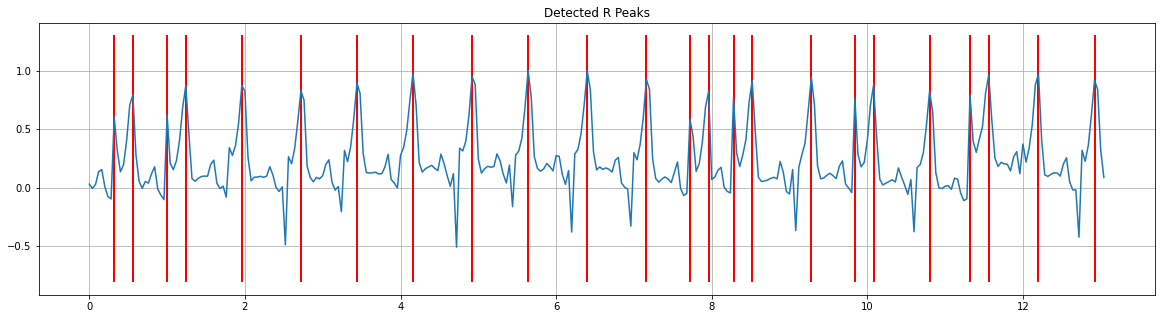

In [26]:
idx = 0

data = np.array(ECG_Norm[idx])

h = np.mean(data[:,0]) + np.std(data[:,0])
r_peaks = find_peaks(data[:,0], height=h)[0] 

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks")

In [27]:
# idx = 3

# data = np.array(ECG_Norm[idx])

# detectors = Detectors(50)
# r_peaks = detectors.christov_detector(data)

# plot_r_peaks(r_min, data, fs, label="Detected R Peaks - Christov Detector")

## generate R - R interval for al signal

In [28]:
ECG_split = []
pad_size = 30
for data in ECG_Norm :
    data = np.array(data)
    
    h = np.mean(data[:,0]) + np.std(data[:,0])
    r_peaks = find_peaks(data[:,0], height=h)[0]
    #r_peaks = detectors.christov_detector(data)
    RRs = np.diff(r_peaks)
    RRs_med = np.median(RRs)
    if not np.isnan(RRs_med) :
        for rp in r_peaks :
            split = data[:,0][rp : rp + int(RRs_med * 1.2)] 
            pad = np.zeros(pad_size)
            n_max = len(split) if len(split) <= pad_size else pad_size
            pad[0:n_max] = split[0:n_max]
            ECG_split.append(pad)

In [29]:
def plot_1_sample(data, fs):
    times = np.arange(data.shape[0]) / fs * 1000 

    plt.plot(times, data)
    plt.title("Plot 1 sample")
    plt.xlabel("Time (ms)")
    plt.ylabel("Normalized Value")
    plt.grid(True)
    plt.show()

In [30]:
ECG_split[1].shape[0]

30

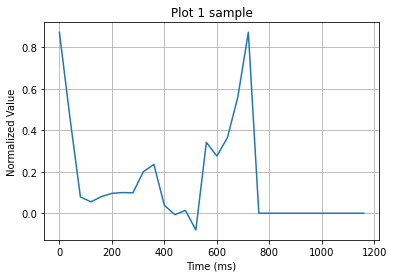

In [39]:
plot_1_sample(ECG_split[3], fs)

___

## Upsampling Signal

In [32]:
from scipy.signal import resample, resample_poly

In [33]:
def upsampling_twice(data):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [34]:
new_fs = 250 # Hz 
ECG_Split_Up = []
for data in ECG_split :
    data = np.array(data)
    data = upsampling_twice(data) 
    data = resample_poly(data, new_fs, int(new_fs/5))
    pad = np.zeros(300)
    pad[:len(data)] = data
    ECG_Split_Up.append(pad)

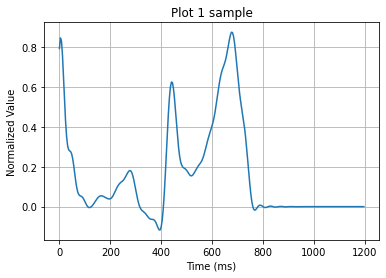

In [35]:
plot_1_sample(ECG_Split_Up[1], fs=new_fs)

In [36]:
ECG_DF = pd.DataFrame(ECG_Split_Up)

In [37]:
ECG_DF.to_csv("dataset/AFDB_pasien_%s_%s" % (data_type, filename), index=False, header=False)